<a href="https://colab.research.google.com/github/Riba-Karp/Python_11_Class/blob/main/Week11_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи перколяции для случайный карт с помощью метода $k$-средних ($k$-means)

Рассмотрим решение задачи перколяции для случайных карт с помощью одного из наиболее популярных методов кластеризации -- метода $k$-средних (англ. $k$-means). Алгоритм осуществляет разбиение множества объектов на заданное пользователем число кластеров $k$, минимизируя суммарное квадратичное отклонение точек кластеров от центров этих кластеров. Посмотрим на иллюстрацию принципа работы алгоритма в случае $k=3$.

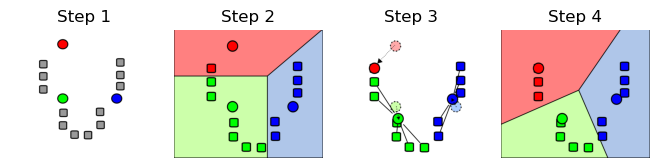

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import requests
from PIL import Image
from io import BytesIO

urls = ["https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/K_Means_Example_Step_1.svg/1062px-K_Means_Example_Step_1.svg.png",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/K_Means_Example_Step_2.svg/1187px-K_Means_Example_Step_2.svg.png",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/K_Means_Example_Step_3.svg/1187px-K_Means_Example_Step_3.svg.png",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/K_Means_Example_Step_4.svg/1187px-K_Means_Example_Step_4.svg.png"]
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}

imgs = []
for url in urls:
    response = requests.get(url, headers = headers)
    imgs.append(Image.open(BytesIO(response.content)))

plt.close("all")
fig, ax = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (17. / 2.54, 8.5 / 2.54))
for i in range(4):
    ax[i].set_title("Step " + "{:d}".format(i + 1))
    ax[i].set_axis_off()
    ax[i].set_axis_off()
    ax[i].imshow(imgs[i])
plt.tight_layout()

На первом шаге в пространстве параметров случайным образом задается $k=3$ средних -- первоначальные центры трех кластеров. На следующем шаге объекты разбиваются по трем кластерам на основе сопоставления расстояний до центров кластеров -- объект относится к заданном кластеру, если расстояние от него до центра этого кластера является наименьшим. На третьем шаге рассчитываются центры масс полученных кластеров, которые становятся новыми $k$-средними. Затем объекты снова перераспределяются по кластерам с учетом новых положений центров кластеров, и процедура повторяется до достижения заданной степени сходимости -- например, когда рассчитанные "новые" центры кластеров совпадают со "старыми" центрами с заданной точностью.

В нашем примере метод $k$-средних можно использовать для классификации карт на перколяционные/неперколяционные, задав $k=2$. Реализуем алгоритм с использованием готовой функции KMeans из модуля sklearn.cluster.

Импортируем необходимые модули.

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns

Задаем начальные параметры, для которых была получена размеченная выборка, и загружаем саму выборку.

In [ ]:
from tqdm import tqdm

l = 50
pp = np.arange(0.4, 0.8, 0.01)
nsamples = 800

# функция для определения индексов соседей узла x, y для карты размером l на l
def find_neighbours(x, y, l):
    nbrs = []
    for d in [(0, -1), (-1, 0), (1, 0), (0, 1)]:
        dx, dy = d
        x1 = x + dx
        y1 = y + dy
        if 0 <= x1 < l and 0 <= y1 < l:
            nbrs.append((x1, y1))
    return nbrs

# функция для поиска в глубину (depth-first search)
def dfs(m, l):
    routes = [(n, 0) for n in range(l) if m[n, 0] == 1]
    end = [(n, l - 1) for n in range(l) if m[n, l - 1] == 1]
    ind = -1
    m1 = m.copy()
    perc = 0
    while True:
        if len(routes) == 0:
            break
        x, y = routes[ind]
        del routes[ind]
        m1[x, y] = -1
        if (x, y) in end:
            perc = 1
            break
        for neighbour in find_neighbours(x, y, l):
            xn, yn = neighbour
            if m1[xn, yn] == 1 and neighbour not in routes:
                routes.append(neighbour)
    return perc

# пробуем загрузить существующие данные и, если их нет, генерируем их
try:
    print("Trying to load existing data")
    mm = np.load("maps_random.npy")
    labels = np.load("labels_random.npy")
    print("Loaded existing data")
except:
    print("Existing data not found, generating new data")
    mm = np.zeros((np.size(pp), nsamples, l, l))
    labels = np.zeros((np.size(pp), nsamples))
    for i in tqdm(range(np.size(pp))):
        for j in range(nsamples):
            m = np.random.choice([0, 1], size = (l, l), p = [1 - pp[i], pp[i]])
            label = dfs(m, l)
            mm[i, j, :, :] = m
            labels[i, j] = label
    print("Generated new data")
    np.save("maps_random.npy", mm)
    np.save("labels_random.npy", labels)

Преобразуем данные к нужному виду и используем алгоритм $k$-средних для классификации карт на перколяционные/неперколяционные.

In [ ]:
X = mm.reshape(-1, l * l)
y = labels.flatten()

kmeans = KMeans(n_clusters = 2, random_state = 1)
y_pred = kmeans.fit_predict(X)
y_pred_reshaped = y_pred.reshape(labels.shape)

### Задача

Проанализируй точность и корректность работы алгоритма на основе `classification_report`, `confusion_matrix` и `accuracy_score`.

Выводим метрики, характеризующие точность алгоритма.

In [ ]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95     15768
         1.0       0.95      0.94      0.95     16232

    accuracy                           0.95     32000
   macro avg       0.95      0.95      0.95     32000
weighted avg       0.95      0.95      0.95     32000



Строим confusion matrix, характеризующую, как предсказанные классы соотносятся с истинными.

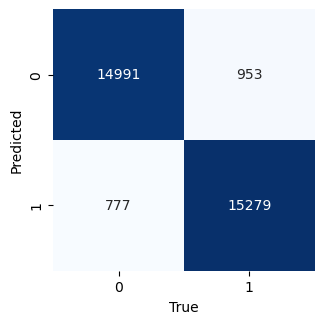

In [ ]:
conf_mat = metrics.confusion_matrix(y, y_pred)

plt.close("all")
fig, ax = plt.subplots(figsize = (8.5 / 2.54, 8.5 / 2.54))
sns.heatmap(conf_mat.T, cmap = "Blues", annot = True, fmt = "d", cbar = False, ax = ax)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
plt.tight_layout()

Выводим метрику accuracy -- соотношение верных предсказаний ко всем.

In [ ]:
print("Accuracy score: " + "{:.4f}".format(metrics.accuracy_score(y, y_pred)))

Accuracy score: 0.9459


## Анализ распределения центров кластеров в алгоритме $k$-средних

Построим карты распределений центров кластеров для кластеров #1 и кластеров #2.

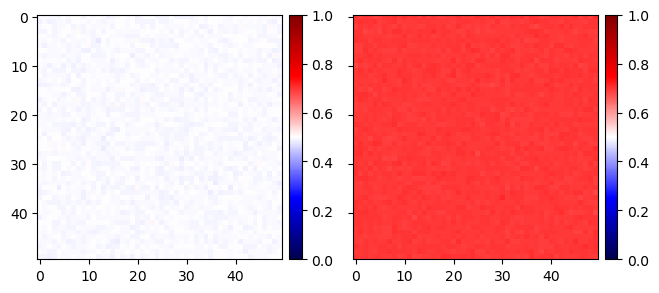

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

centers = kmeans.cluster_centers_.reshape(2, l, l)

fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17. / 2.54, 8.5 / 2.54))
for i in range(2):
    im = ax[i].imshow(centers[i], cmap = "seismic", vmin = 0., vmax = 1.)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", "5%", pad = "3%")
    plt.colorbar(im, cax = cax)
plt.tight_layout()

Уже можно видеть, что распределения центров кластеров отличаются для кластеров первого и второго типа -- при достаточно высокой степени однородности средние значения для двух профилей оказываются различными. Полученный результат можно сопоставить с усредненной неперколяционной и перколяционной картой в выборке.

### Задача

Проведи усреднение по всей выборке значений в узлах отдельно для всех неперколяционных и перколяционных карт, построй усредненные двумерные распределения и сопоставь их с распределениями центров кластеров, полученными с помощью алгоритма $k$-средних.

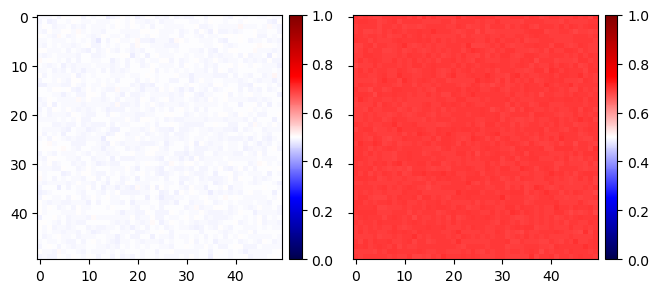

In [ ]:
indexes_no_perc = np.argwhere(y == 0.)
indexes_perc = np.argwhere(y == 1.)

maps_no_perc = X[indexes_no_perc].reshape(-1, l, l)
maps_perc = X[indexes_perc].reshape(-1, l, l)

means = [np.mean(maps_no_perc, axis = 0), np.mean(maps_perc, axis = 0)]

fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (17. / 2.54, 8.5 / 2.54))
for i in range(2):
    im = ax[i].imshow(means[i], cmap = "seismic", vmin = 0., vmax = 1.)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", "5%", pad = "3%")
    plt.colorbar(im, cax = cax)
plt.tight_layout()

Как видно, распределения центров кластеров в выборке в среднем хорошо воспроизводят усредненную неперколяционную и перколяционную карты. Усредним распределения центров кластеров вдоль одного из направлений и построим одномерные профили центров кластеров.

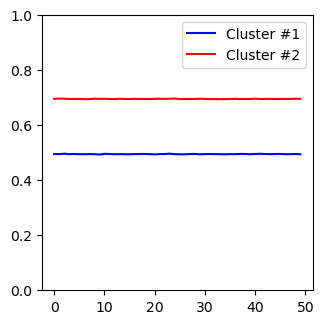

In [ ]:
fig, ax = plt.subplots(figsize = (8.5 / 2.54, 8.5 / 2.54))
ax.set_ylim(0., 1.)
ax.plot(centers[0].mean(axis = 0), c = "b", label = "Cluster #1")
ax.plot(centers[1].mean(axis = 0), c = "r", label = "Cluster #2")
ax.legend()
plt.tight_layout()

Действительно, центры кластеров разнесены на некоторую величину. Посчитаем средние значения по всей карте, чтобы оценить, на сколько в среднем отличаются центры кластеров.

In [ ]:
print("Mean value for cluster #1: " + "{:.4f}".format(centers[0].mean()))
print("Mean value for cluster #2: " + "{:.4f}".format(centers[1].mean()))

Mean value for cluster #1: 0.4944
Mean value for cluster #2: 0.6948


## Зависимость точности решения от концентрации

Посмотрим, какую точность показывает метод $k$-средних при различных значениях концентрации $p$. Для этого посчитаем `accuracy_score` для различных подвыборок, каждая из которых соответствует определенному значению $p$.

### Задача

Запиши в пустой список `acc_scores` `accuracy_score` для различных частей выборки, отвечающих в каждом случае определенному фиксированному значению концентрации $p$, построй на одном графике зависимость точности предсказаний (`accuracy_score`) от концентрации $p$, а также зависимость от $p$ доли карт, где есть перколяция, и доли карт, где ее нет; вертикальными линиями (функция `vlines` из модуля `matplotlib`) отметь положения центров каждого из кластеров и центра масс всех представленных в выборке объектов.

In [ ]:
acc_scores = []
for i in range(np.size(pp)):
    acc_score = metrics.accuracy_score(labels[i, :], y_pred_reshaped[i, :])
    acc_scores.append(acc_score)

Приведем на одном графике зависимость точности предсказаний (accuracy score) от концентрации $p$, а также зависимости от $p$ доли карт, где есть перколяция, и доли карт, где ее нет. Отметим вертикальными линиями положения центров каждого из кластеров и центра масс всех представленных в выборке объектов.

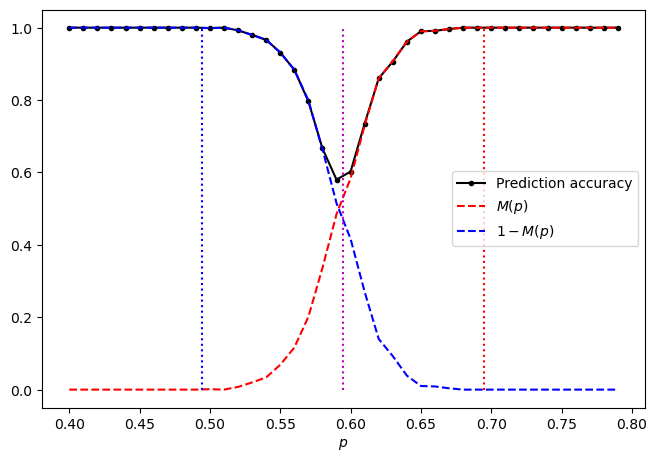

In [ ]:
fig, ax = plt.subplots(figsize = (17. / 2.54, 12. / 2.54))
ax.set_xlabel("$p$")
ax.plot(pp, acc_scores, ".-", c = "k", label = "Prediction accuracy")
ax.plot(pp, np.mean(labels, axis = 1), c = "r", ls = "--", label = "$M(p)$")
ax.plot(pp, 1. - np.mean(labels, axis = 1), c = "b", ls = "--", label = "$1 - M(p)$")
ax.vlines(centers[0].mean(), 0., 1., ls = "dotted", color = "b")
ax.vlines(centers[1].mean(), 0., 1., ls = "dotted", color = "r")
ax.vlines(centers.mean(), 0., 1., ls = "dotted", color = "m")
ax.legend()
plt.tight_layout()

На полученных кривых можно видеть, что точность существенно падает вблизи порога перколяции, снижаясь в минимуме, при $p \simeq 0.6$, до $\simeq 60$ %. При этом $p \simeq 0.6$ соответствует также точке, равноотстоящей от центров первого и второго кластеров, отмеченных вертикальными линиями разного цвета. Следовательно, вблизи этой точки объекты одного класса с большой вероятностью могут быть ошибочно отнесены к объектам другого класса, что и наблюдается в нашем примере. Вдали от порога перколяции точность приближается к $100$ %, при этом кривая точности практически идеально совпадает с кривыми, описывающими долю перколяционных кластеров при $p>p_0 \simeq 0.6$~(обозначена на графике как $M(p)$, синяя кривая) и долю неперколяционных кластеров при $p<p_0 \simeq 0.6$ (обозначена на графике как $1 - M(p)$, красная кривая), соответственно.

## Зависимость точности решения от равномерности выборки

Отметим также, что результаты кластеризации с помощью метода $k$-средних могут зависеть от равномерности анализируемой выборки -- если объекты одного класса будут представлены в ней в большей степени, чем объекты другого класса, центры кластеров и, соответственно, принадлежность объектов к определенному классу, могут определяться некорректно. Попробуем показать это, сделав их исходных данных такие подвыборки, чтобы в одной из них было больше перколяционных карт, а в другой -- неперколяционных. Для этого "вырежем" некоторое количество карт из начала и из конца выборки и создадим из полученных массивов новые выборки, для которых реализуем решение с помощью метода $k$-средних.

In [ ]:
skip = 10
pp1 = pp[skip :]
pp2 = pp[: np.size(pp) - skip]
mm1 = mm[skip :]
mm2 = mm[: np.size(pp) - skip]
labels1 = labels[skip :]
labels2 = labels[: np.size(pp) - skip]

X1 = mm1.reshape(-1, l * l)
X2 = mm2.reshape(-1, l * l)
y1 = labels1.flatten()
y2 = labels2.flatten()

kmeans1 = KMeans(n_clusters = 2, random_state = 1)
y1_pred = kmeans1.fit_predict(X1)
y1_pred_reshaped = y1_pred.reshape(labels1.shape)
centers1 = kmeans1.cluster_centers_.reshape(2, l, l)

kmeans2 = KMeans(n_clusters = 2, random_state = 1)
y2_pred = kmeans2.fit_predict(X2)
y2_pred_reshaped = y2_pred.reshape(labels2.shape)
centers2 = kmeans2.cluster_centers_.reshape(2, l, l)

### Задача

Рассчитай зависимость `accuracy_score` от концентрации для двух неравномерных выборок. Построй на одном графике зависимость `accuracy_score` от концентрации, доли перколяционных и неперколяционных карт и положения центров кластеров для двух неравномерных выборок. Как изменяется `accuracy_score` при неравномерности выборки?

In [ ]:
acc_scores1 = []
acc_scores2 = []
for i in range(np.size(pp1)):
    acc_score1 = metrics.accuracy_score(labels1[i, :], y1_pred_reshaped[i, :])
    acc_scores1.append(acc_score1)
for i in range(np.size(pp2)):
    acc_score2 = metrics.accuracy_score(labels2[i, :], y2_pred_reshaped[i, :])
    acc_scores2.append(acc_score2)

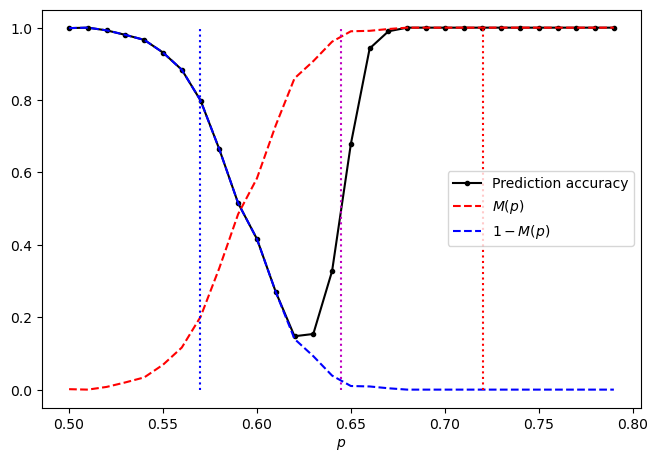

In [ ]:
fig, ax = plt.subplots(figsize = (17. / 2.54, 12. / 2.54))
ax.set_xlabel("$p$")
ax.plot(pp1, acc_scores1, ".-", c = "k", label = "Prediction accuracy")
ax.plot(pp1, np.mean(labels1, axis = 1), c = "r", ls = "--", label = "$M(p)$")
ax.plot(pp1, 1. - np.mean(labels1, axis = 1), c = "b", ls = "--", label = "$1 - M(p)$")
ax.vlines(centers1[0].mean(), 0., 1., ls = "dotted", color = "b")
ax.vlines(centers1[1].mean(), 0., 1., ls = "dotted", color = "r")
ax.vlines(centers1.mean(), 0., 1., ls = "dotted", color = "m")
ax.legend()
plt.tight_layout()

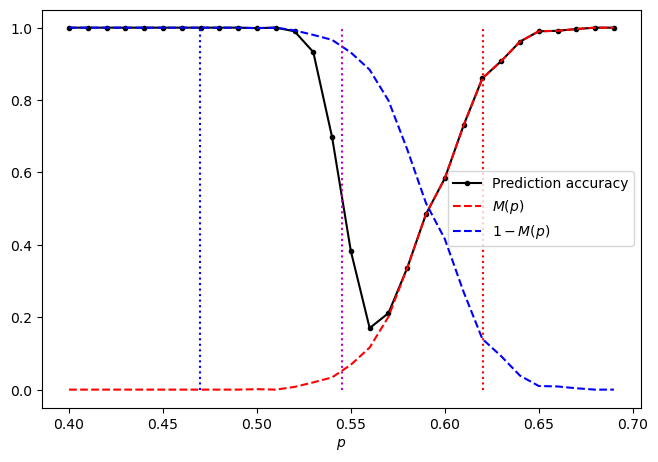

In [ ]:
fig, ax = plt.subplots(figsize = (17. / 2.54, 12. / 2.54))
ax.set_xlabel("$p$")
ax.plot(pp2, acc_scores2, ".-", c = "k", label = "Prediction accuracy")
ax.plot(pp2, np.mean(labels2, axis = 1), c = "r", ls = "--", label = "$M(p)$")
ax.plot(pp2, 1. - np.mean(labels2, axis = 1), c = "b", ls = "--", label = "$1 - M(p)$")
ax.vlines(centers2[0].mean(), 0., 1., ls = "dotted", color = "b")
ax.vlines(centers2[1].mean(), 0., 1., ls = "dotted", color = "r")
ax.vlines(centers2.mean(), 0., 1., ls = "dotted", color = "m")
ax.legend()
plt.tight_layout()

Как можно видеть, неравномерность выборки по соотношению перколяционных и неперколяционных карт, появляющаяся в результате удаления части данных для больших или малых концентраций из этой выборки, приводит к существенно отличным результатам -- центры кластеров определяются по другому -- смещаются в область больших концентраций, если из выборки убирается часть данных для малых концентраций, и в область малых концентраций, если из выборки убирается часть данных для больших концентраций. В результате точность в промежутке между центрами двух кластеров падает более существенным образом, чем в случае равномерной выборки, центр диапазона по концентрации для которой приходится на $p=p_0 \simeq 0.6$. В худшем случае точность снижается до всего $\simeq 20$ %. Точность предсказаний для всей выборки в целом также страдает. В то время как для исходной выборки она составляет $\simeq 95$ %, для двух последних получается следующий результат:

In [ ]:
print("Accuracy score: " + "{:.4f}".format(metrics.accuracy_score(y1, y1_pred)))
print("Accuracy score: " + "{:.4f}".format(metrics.accuracy_score(y2, y2_pred)))

Accuracy score: 0.8219
Accuracy score: 0.8408


В заключении, отметим достоинства и недостатки алгоритма $k$-средних. К первым можно отнести сравнительную простоту реализации, а также отсутствие необходимости в разделении выборки на обучающую и тестовую. К недостаткам можно отнести зависимость результатов кластеризации от соотношения числа объектов разных классов в анализируемой выборке. В нашем случае алгоритм показывает низкую точность при анализе данных вблизи порога перколяции по концентрации, при этом ошибки классификации существенно возрастают для неравномерной выборки.